In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2
import json

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(3)

In [3]:
import re
import numpy as np
from tqdm import tqdm
import shutil
from skimage import measure
from scipy import ndimage
import cv2
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras
from skimage import exposure, filters
from sklearn import metrics

2022-10-14 14:44:58.096660: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Funciones

In [4]:
def recolor_resize(img, pix=256):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    img = cv2.resize(img, (pix, pix))
    img = np.expand_dims(img, axis=-1)
    return img


def recolor(img):
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    except:
        print('', end = '')
    return img


def normalize(img):
    return (img - np.mean(img))/ np.std(img)


def quitar_trozos(mask):
    mask = measure.label(mask)
    ntotal = {k: (k==mask).sum() for k in np.unique(mask) if k >0}
    k = list(ntotal.keys())[np.argmax(list(ntotal.values()))]
    mask = k==mask
    mask = ndimage.binary_fill_holes(mask, structure=np.ones((5,5)))
    return mask


def des_normalize(img):
    return cv2.normalize(img, None, alpha = 0, beta = 255,
                         norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_16UC1)


def apply_mask(img, model):
    pix1 = img.shape[0]
    pix2 = img.shape[1]
    # Paso la imagen a escala de grises
    img = recolor(img)
    # Creo una nueva imagen con las dimensiones de entrada al modelo
    img_2 = normalize(recolor_resize(img, 256))[np.newaxis,...]
    # Genero la mascara
    mask = model.predict(img_2)[0,...]
    # Escalo la mascara generada al tamaño de la imagen de entrada
    mask = cv2.resize(mask, (pix2, pix1))
    # Limpio la mascara
    mask = quitar_trozos(mask > 0.5)
    return img*mask


model_mask = os.path.join('/home/mr1142/Documents/Data/models/mascaras/unet_final_renacimiento_validation_6.h5')
model_mask = keras.models.load_model(model_mask, 
                                    custom_objects={"loss_mask": tf.keras.losses.BinaryCrossentropy, 
                                                    "dice_coef_loss": tf.keras.losses.BinaryCrossentropy,
                                                    "dice_coef": tf.keras.losses.BinaryCrossentropy})


def equalize(img, clip_limit=0.01, med_filt=5,output_type='uint16', flag_draw=False,):
    if img.dtype is np.dtype(np.float32):
        img_norm = img / img.max()                                    # Format adaptation
    else:
        img_norm = img.astype('float32') / np.iinfo(img.dtype).max                  # Format adaptation
    img_clahe = exposure.equalize_adapthist(img_norm, clip_limit=clip_limit)        # CLAHE
    img_clahe_median = filters.median(img_clahe,np.ones((3,3,1))).astype('float32')   # Median Filter

    lower, upper = np.percentile(img_clahe_median.flatten(), [2, 98])
    img_clip = np.clip(img_clahe_median,lower, upper)
    img_out = (img_clip - lower)/(upper - lower)

    if output_type is not None:
        max_val=np.iinfo(output_type).max
        img_out=(max_val*img_out).astype(output_type)
    else:
        max_val=1.0
    return img_out


def clahe(img):
    clahe = cv2.createCLAHE(clipLimit = 2)
    img = np.uint8(img)
    final_img = clahe.apply(img)
    final_img = np.expand_dims(final_img, axis=-1)
    return final_img


def get_prepared_img(img, pix, mask = False, clahe_bool = True, equalize_bool = False):
    if equalize_bool:
        img = equalize(img)
    if mask:
        img = des_normalize(apply_mask(img, model_mask))
    img = recolor_resize(img, pix)
    if clahe_bool:
        img = clahe(img)
    img = normalize(img)
    return img

2022-10-14 14:45:05.942009: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 14:45:06.716713: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10405 MB memory:  -> device: 0, name: GeForce GTX 1080 Ti, pci bus id: 0000:0a:00.0, compute capability: 6.1


# MODELO

In [5]:
[modelo for modelo in os.listdir('/home/mr1142/Documents/Data/models/neumonia/') if bool(re.search('completo', modelo))]

['completo_layer_mask_Xception_fine-05_batch-8_lr-0001_auc-99.h5',
 'completo_layer_mask_Xception_fine-03_batch-8_lr--05_auc-99.h5',
 'completo_layer_mask_Xception_fine-03_batch-8_lr-0001_auc-99.h5',
 'completo_3_Xception_fine-08_batch-8_lr-0001_auc-98.h5',
 'completo_mask_Xception_fine-03_batch-8_lr-0001_auc-99.h5',
 'completo_4_Xception_fine-05_batch-8_lr-0001_auc-99.h5',
 'completo_2_Xception_fine-03_batch-8_lr-0001_auc-99.h5',
 'completo_2_Xception_fine-05_batch-8_lr--05_auc-99.h5',
 'completo_layer_Xception_fine-05_batch-8_lr-0001_auc-99.h5',
 'completo_layer_Xception_fine-03_batch-8_lr-0001_auc-99.h5',
 'completo_layer_2_Xception_fine-05_batch-8_lr--05_auc-99.h5',
 'completo_layer_2_Xception_fine-03_batch-8_lr-0001_auc-99.h5',
 'completo_Xception_fine-03_batch-8_lr--05_auc-99.h5',
 'completo_4_Xception_fine-08_batch-8_lr-0001_auc-98.h5',
 'completo_layer_2_Xception_fine-03_batch-8_lr--05_auc-99.h5']

In [6]:
model_name = 'completo_4_Xception_fine-08_batch-8_lr-0001_auc-98'

In [7]:
model_path = '/home/mr1142/Documents/Data/models/neumonia/'+ model_name + '.h5'
neumonia_model = tf.keras.models.load_model(model_path)

## PEDIATRIC

In [8]:
def create_dataframe(folder, path = '/home/mr1142/Documents/Data/chest_xray'):
    path = os.path.join('/home/mr1142/Documents/Data/chest_xray', folder)
    for fold in os.listdir(path):
        globals()[fold] = {}
        imgs = os.listdir(os.path.join(path, fold))
        globals()[fold]['path'] = [os.path.join(path, fold)] * len(imgs)
        globals()[fold]['img_name'] = imgs
        globals()[fold]['normal'] = [1 if fold == 'NORMAL' else 0 for _ in range(len(imgs))]
        globals()[fold]['viral'] = [1 if re.search('virus', imgs[i]) else 0 for i in range(len(imgs))]
        globals()[fold]['bacteria'] = [1 if re.search('bacteria', imgs[i]) else 0 for i in range(len(imgs))]
        globals()[fold]['real'] = [0 if fold == 'NORMAL' else 1 if re.search('virus', imgs[i]) else 2 for i in range(len(imgs))]

    for k, v in PNEUMONIA.items():
        v.extend(NORMAL[k])

    df = pd.DataFrame(PNEUMONIA)

    return df

In [9]:
ped = create_dataframe('train')
ped = pd.concat([create_dataframe('train'), create_dataframe('test')], ignore_index = True)

In [10]:
ped['path'] = [os.path.join(ped.path[i], ped.img_name[i]) for i in ped.index]

In [11]:
ped.head()

,path,img_name,normal,viral,bacteria,real
0,/home/mr1142/Documents/Data/chest_xray/train/P...,person1384_bacteria_3522.jpeg,0,0,1,2
1,/home/mr1142/Documents/Data/chest_xray/train/P...,person783_bacteria_2687.jpeg,0,0,1,2
2,/home/mr1142/Documents/Data/chest_xray/train/P...,person1619_bacteria_4268.jpeg,0,0,1,2
3,/home/mr1142/Documents/Data/chest_xray/train/P...,person551_virus_1091.jpeg,0,1,0,1
4,/home/mr1142/Documents/Data/chest_xray/train/P...,person907_virus_1563.jpeg,0,1,0,1


# EXPLANATION

In [12]:
from scipy.ndimage import zoom

In [13]:
import matplotlib.cm as cm
from IPython.display import Image, display

In [14]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    return superimposed_img

In [16]:
pixels = 512
if bool(re.search('mask', model_name)):
    mask = True
else:
    mask = False

In [17]:
i = np.random.randint(1000)
sano = ped[ped['normal'] == 1].iloc[i]
enfermo = ped[ped['normal'] == 0].iloc[i]
sano_im = cv2.imread(sano.path)
enf_im = cv2.imread(enfermo.path)
sano_prepared = np.expand_dims(get_prepared_img(sano_im, pixels, mask = mask), axis = 0)
enf_prepared = np.expand_dims(get_prepared_img(enf_im, pixels, mask = mask), axis = 0)

2022-10-14 14:45:11.807081: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


1/1 [==============================] - 0s 23ms/step
                     0.000289486488327384                                 0.0462840236723423


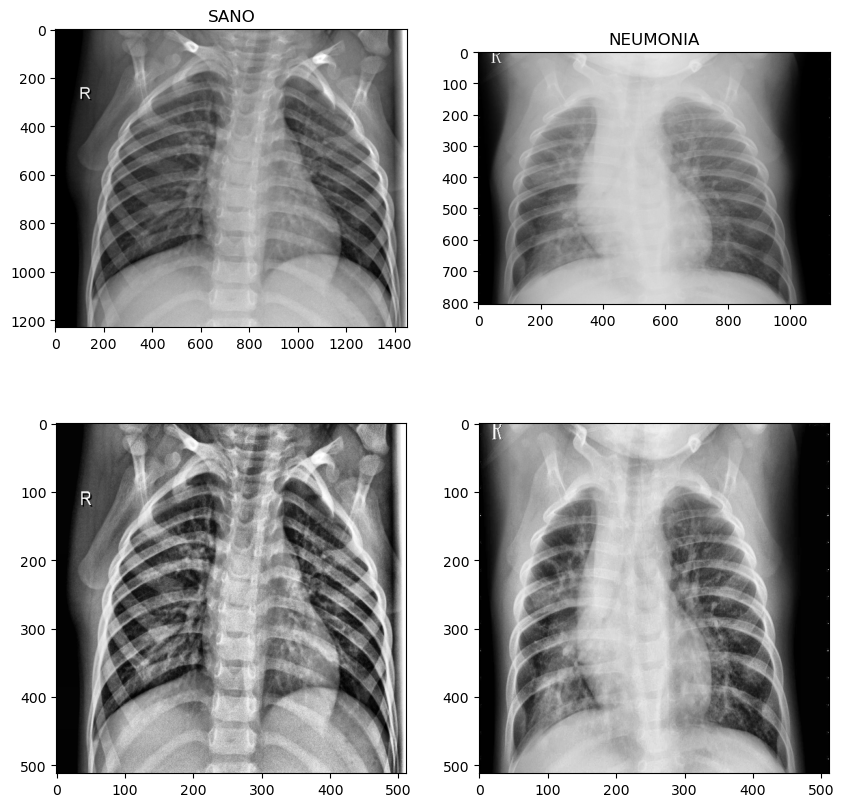

In [18]:
figure, axis = plt.subplots(2,2)
figure.set_size_inches(10,10)
axis[0,0].imshow(sano_im)
axis[0,0].set_title('SANO')
axis[0,1].imshow(enf_im)
axis[0,1].set_title('NEUMONIA')
axis[1,0].imshow(sano_prepared[0,...], cmap = 'gray')
axis[1,1].imshow(enf_prepared[0,...], cmap = 'gray')
print('                     {}                                 {}'.format(neumonia_model.predict(sano_prepared)[0][0], neumonia_model.predict(enf_prepared)[0][0]))

In [19]:
model1 = tf.keras.models.Model(neumonia_model.inputs, neumonia_model.layers[0].output)
model = tf.keras.models.Model([neumonia_model.input, neumonia_model.layers[1].input], [neumonia_model.layers[1].output, neumonia_model.output])

In [20]:
img = enf_prepared
conv, pred = model.predict([img, model1(img)])

1/1 [==============================] - 1s 935ms/step


In [21]:
heatmap = make_gradcam_heatmap(enf_prepared, neumonia_model, 'conv_salida')
# Display heatmap
# plt.matshow(heatmap)
# plt.show()

ValueError: No such layer: conv_salida. Existing layers are: ['conv_inicial', 'xception', 'general_max_pooling', 'dropout_out_1', 'dense', 'dense_1', 'dropout_out_2', 'dense_2', 'fc_out'].

NameError: name 'heatmap' is not defined

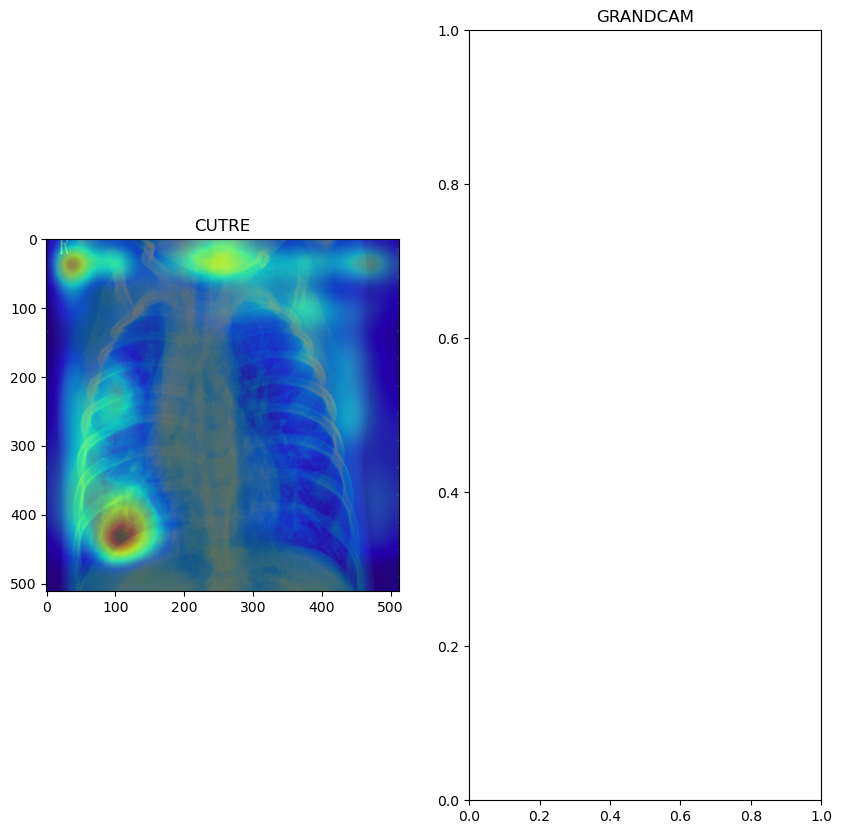

In [22]:
scale = 224 / 7
figure, axis = plt.subplots(1,2)
figure.set_size_inches(10,10)
axis[0].set_title('CUTRE')
axis[0].imshow(img[0,...])
axis[0].imshow(zoom(np.sum(conv, axis = 3).squeeze(), zoom=(scale, scale)), cmap='jet', alpha=0.5)
axis[1].set_title('GRANDCAM')
axis[1].imshow(save_and_display_gradcam(enf_im, heatmap))

# Añadir una capa y cargar pesos

In [23]:
from tensorflow.keras.applications import Xception

In [24]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [25]:
from keras import models
def freeze(model):
    """Freeze model weights in every layer."""
    for layer in model.layers:
        layer.trainable = True

        if isinstance(layer, models.Model):
            freeze(layer)
    model.save("./model.h5")    

In [26]:
def crear_modelo(input_shape = (512,512,3)):
    from keras import backend as K
    K.clear_session()
    inputs = layers.Input(shape=(512,512,1))
    x = layers.Conv2D(3,3,padding="same", activation='elu', name = 'conv_inicial')(inputs)
    backbone = Xception(weights=None, include_top=False, input_shape=input_shape, input_tensor = x)
    back_output = backbone.get_layer('block14_sepconv1_act').output
    x = layers.SeparableConv2D(2048,(3,3), name = 'block14_sepconv2', padding = 'same', use_bias = False)(back_output)
    x = layers.BatchNormalization(name = 'block14_sepconv2_bn')(x)
    x = layers.Activation(activation = 'relu', name = 'block14_sepconv2_act')(x)

    x = layers.GlobalMaxPooling2D(name="general_max_pooling")(x)
    x = layers.Dropout(0.2, name="dropout_out_1")(x)
    x = layers.Dense(768, activation="elu", name = 'dense')(x)
    x = layers.Dense(128, activation="elu", name = 'dense_1')(x)
    x = layers.Dropout(0.2, name="dropout_out_2")(x)
    x = layers.Dense(32, activation="elu", name = 'dense_2')(x)
    output = layers.Dense(3, activation="softmax", name="fc_out")(x)
    
    model = tf.keras.Model(inputs=inputs, outputs= output , name="U-Net")
    return model

In [27]:
def cargar_pesos(old, new):
    for layer in new.layers:
        try:
            new.get_layer(layer.name).set_weights(old.get_layer(layer.name).get_weights())
        except:
            new.get_layer(layer.name).set_weights(old.get_layer('xception').get_layer(layer.name).get_weights())
            try: 
                new.get_layer(layer.name).set_weights(old.get_layer('xception').get_layer(layer.name).get_weights())
            except:
                print(str(layer.name) + ' not found')
    return new

In [28]:
new = crear_modelo()

In [30]:
new = cargar_pesos(neumonia_model, new)

In [1]:
i = np.random.randint(1000)
sano = ped[ped['normal'] == 1].iloc[i]
enfermo = ped[ped['normal'] == 0].iloc[i]
sano_im = cv2.imread(sano.path)
enf_im = cv2.imread(enfermo.path)
sano_prepared = np.expand_dims(get_prepared_img(sano_im, pixels, mask = mask), axis = 0)
enf_prepared = np.expand_dims(get_prepared_img(enf_im, pixels, mask = mask), axis = 0)

NameError: name 'np' is not defined

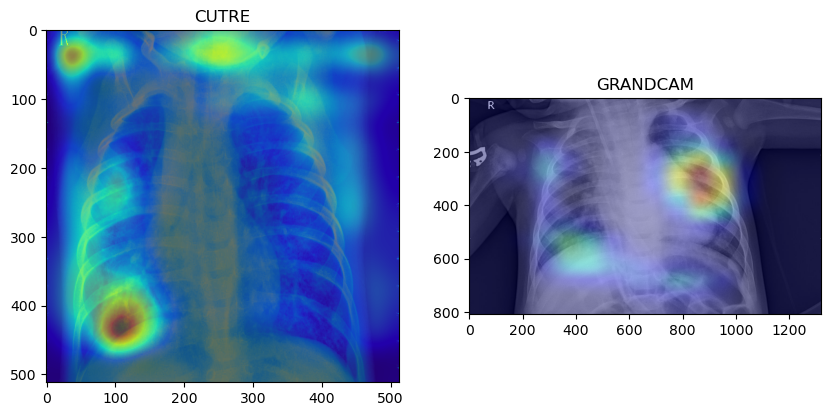

In [38]:
heatmap = make_gradcam_heatmap(enf_prepared, new, 'block14_sepconv2_act')
scale = 224 / 7
figure, axis = plt.subplots(1,2)
figure.set_size_inches(10,10)
axis[0].set_title('CUTRE')
axis[0].imshow(img[0,...])
axis[0].imshow(zoom(np.sum(conv, axis = 3).squeeze(), zoom=(scale, scale)), cmap='jet', alpha=0.5)
axis[1].set_title('GRANDCAM')
axis[1].imshow(save_and_display_gradcam(enf_im, heatmap))

1/1 [==============================] - 0s 29ms/step
                     0.0007817702717147768                                 0.0005493580247275531
1/1 [==============================] - 0s 21ms/step
                     0.0007817702717147768                                 0.0005493580247275531


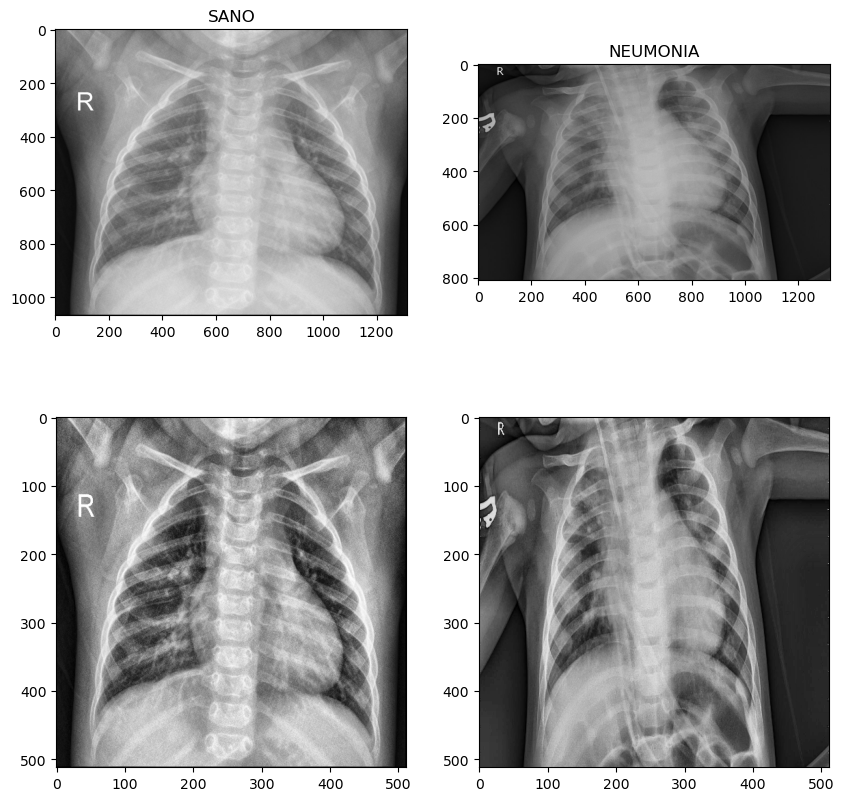

In [39]:
figure, axis = plt.subplots(2,2)
figure.set_size_inches(10,10)
axis[0,0].imshow(sano_im)
axis[0,0].set_title('SANO')
axis[0,1].imshow(enf_im)
axis[0,1].set_title('NEUMONIA')
axis[1,0].imshow(sano_prepared[0,...], cmap = 'gray')
axis[1,1].imshow(enf_prepared[0,...], cmap = 'gray')
print('                     {}                                 {}'.format(neumonia_model.predict(sano_prepared)[0][0], neumonia_model.predict(enf_prepared)[0][0]))
print('                     {}                                 {}'.format(new.predict(sano_prepared)[0][0], new.predict(enf_prepared)[0][0]))